Several things of note:
* The task is in the form of a supervised problem.
* Initially there are 2 target values to an equal or larger range of feature values.
    * Target values at face value, are a 1x2 array, whereas features will depend on our selection of time intervals and will be of the form Nx6, where N is $\frac{\Delta t}{\delta t}$; $\Delta T$, how far back in time before the 'present' we take values from, and $\delta t$ the time interval length (1 min. in our case).
        * This means that we have a hyperparameter $\Delta T$ that we need to decide on how we tune.
            * The most apparent ways we can do this are:
                1. We simply take the best performing overall value for it; this being after fitting for each potential value and potential data set and comparing. (i.e. Grid search)
                2. We use another supervised model to predict the best performing hyper-parameter given the feature data. 
                    * This could also involve deciding the parameters of a weighting function that gives a weight as a function of $n \cdot \delta t$, where n is the interval number.  
                    * The reason to do this would be that potentially the current conditions will determine how far in the past  and how much predictive power the data holds. (e.g. A high current speed may mean that only very recent data is relevant.)
                3. We take an arbitrary number we decide via some intuitive reason.
            
            * This will likely be unnecessary for the Neural networks as they will likely account for the weighting if we feed it the entire intervals data.

        * We can take this array from the larger array of predicted values that most models would output.
            * This allows us to use the lag approach.
            

* Potential models we will try to work with are:
    * Various linear models:
        * These will be basic, but they could potentially be a good fit.
        
    * Random Forest regressor
        * Values are constrained in a range so the predicting power of a rfr may be very good.
        
    * Neural networks:
        * Artificial Neural network.
        * Recurrent Neural network.
        * Potentially deep variants of the above.
    
* 

We will start by loading in the data and formating it (since we know what the data looks like) into usable objects.

In [1]:
import pandas as pd
import numpy as np
from statistics import mean 

# load data into readable pandas dataframe of features, X
X = pd.read_csv("../../../data/sag_data_train.csv", index_col="Time", parse_dates=True) 

# convert unformatted into potentially useful numpy format (index is effectively minutes from start)
df_train = pd.read_csv("../../../data/sag_data_train.csv", parse_dates=True)

Xarr = df_train.to_numpy()

# remove time column
Xarr = np.delete(Xarr, 0, 1)

# rearrange so targets are on right
targets = Xarr[:,0:2]
Xarr = np.hstack((Xarr,targets))
Xarr = np.delete(Xarr, [0,1] , 1)

Xarr


array([[7.843532336863314, 1030.5901079882124, 2935.660276152265,
        38.64101791, 5488.175539727612, 11.737356515341975],
       [7.681607109179845, 1039.8698466702335, 2928.333772398626,
        45.24365616, 5423.93012617854, 11.543755166261553],
       [7.514173279340541, 1033.2372048485997, 2919.1281147618697,
        38.71622086, 5502.058523342791, 11.16952458197278],
       ...,
       [8.405826447527717, 932.9824670593828, 2877.573304216864,
        40.47877502, 5260.32185762985, 13.392879121831513],
       [8.239607449049426, 951.2825779170732, 2882.3853905260717,
        47.95565796, 5244.054888523173, 13.10375519149619],
       [8.15488899261671, 971.2098860971196, 2861.211279050305,
        47.9231987, 5281.921059587213, 13.024094581994502]], dtype=object)

Though we know there are a couple NAN values, they could be replaced with a sample mean/median value later as to prevent information leakage between training and tets sets.

In [2]:
"""
Due to time and processing power constraints we will cut our data down in size significantly.
Bear this in mind if the data contradicts what is being.
"""

#Xarr = np.delete(Xarr, slice(0,5000), 0)

#Xarr = np.delete(Xarr, slice(15000, Xarr.shape[0]-1), 0)


Xarr = Xarr[ 25000:30000, :]
Xarr

array([[8.101647471696031, 873.0851779784513, 2852.5989332409376,
        46.21428299, 5405.417261852194, 12.647642714718168],
       [8.101204696670724, 872.8418764687068, 2805.952028132609,
        42.74369049, 5420.343951850704, 12.682522010182161],
       [8.100761922581778, 919.3479448794836, 2837.570360752269,
        41.118927, 5401.304281441732, 12.65203169918472],
       ...,
       [8.4259512904778, 1078.7883803619054, 2864.1288951795455,
        44.74312973, 5493.264471579962, 13.606373397687818],
       [8.424648682603681, 1060.0573525633752, 2801.392315692223,
        39.81977463, 5478.198193228236, 13.556308009611785],
       [8.423706855281504, 1045.0455944529467, 2864.534425198114,
        42.93088913, 5485.223712860796, 13.534680924206636]], dtype=object)

Next, we will format our data into the supervised form via producing a set of lag columns. In order to reduce the training time, while making sure the model fit is looking at a relevant timeframe, we will choose to split the data into 25 minute intervals. The variables outside of this timeframe shouldn't have too much predicting power, so we shouldn't lose too much with regards to that. We will also simultaneously remove the rows at the head of the dataframe that won't have values.

In [3]:
from IPython.display import clear_output # allows us to keep track of progress

# generalised function
def timeseries_supervised_conversion(data, lag, lead_time, target_col_indices=[1], interval_length=1, display_column_index=0): # we will use the index to indicate the time interval, so input data needs to be of a regular format
     
    n_rows = data.shape[0]
    n_columns = data.shape[1]
    row_n = 0
    new_array_row_n = 0
    new_data = [] # lists are used for optimisation reasons
    
    # iterate over rows and columns to append new values
    for row in data:
        if row_n < lag or ( n_rows-1 - row_n ) < lead_time : # skip rows that return with empty values
            row_n += 1
            continue
            
        else:
            altered_row = []
            altered_row.extend(row)
            # iteratively append new targets and features
            for L in range(1, lag+1): # All values at every -1 interval are effectively new  features. Skip the first value as it is the original target value
                altered_row.extend(data[row_n - L, :])
                
            for col in target_col_indices:
                for lead in range(1, lead_time+1): # every +1 interval of target columns are the targets
                    altered_row.append(data[row_n + lead, col])
                
            new_data.extend(altered_row)
            row_n += 1
            new_array_row_n += 1 # for reshaping
            
            clear_output(wait=True) # allows us to keep track of progress
            display(new_data[display_column_index], '\n ... \n', new_data[len(altered_row)*(new_array_row_n) - 1 + display_column_index])

        
    new_data = np.array(new_data).reshape(new_array_row_n, n_columns*(lag+1) + lead_time*len(target_col_indices))
    
    clear_output(wait=True)
    display(new_data)
    
    target_first_index = n_columns*(1+lag)  # for now we can print and input manually , but could be automated via dict() or similar.
    print("\n target column indices start at:", target_first_index )# target columns will be on the right side of the array
    
    return new_data  

In [4]:
X_supervised_full = timeseries_supervised_conversion(Xarr, 20, 5, target_col_indices=[4,5]) 
display('\n Shape:', X_supervised_full.shape,'\n single row looks like: \n', X_supervised_full[0])

7.9908983210870215

'\n ... \n'

13.152723333455588

For our problem we are only looking at the 5 minute window. Thus, we can remove the other target columns. 

In [5]:
target_first_index_here = 126

X_supervised = np.delete(X_supervised_full, slice(target_first_index_here + 6*1 + 5, X_supervised_full.shape[1]), 1) # 5 is lead_time, 6 is col_n, and 1 is number of target variables-1
X_supervised = np.delete(X_supervised, slice(target_first_index_here + 5, X_supervised_full.shape[1] - 1), 1)
X_supervised = np.delete(X_supervised, slice(target_first_index_here, target_first_index_here + 4), 1)
display(X_supervised.shape, X_supervised, X_supervised[0])

This now means that the single target column has an index of the previous first target.



[On timeframe segmentation-validation method]: 

Since we have so many timeframes to consider and not many NAN values, we can simply remove the whole timeframes wtih them in. This can be done while we split the data into the different timeframes for validation and independent modelling. Here we will start with an arbitrary split of 25 minute timeframes that can be tuned down further in the future if necessary. 

To do this we define the function:

In [6]:
# split time series data into sets of relevant sizes 
def time_series_split(integer_time_indexed_array, timeframe, remove_nan_data=False, min_test_size=5, start_time=0, end_time=False): # the units being the smallest time interval indicated by the index
    timeframe_n = {}
    
    if end_time == False:
        end_time = integer_time_indexed_array.shape[0]-1
        
    considered_data = integer_time_indexed_array[start_time:end_time+1,:]
    
    for i in range( round(considered_data.shape[0]/(timeframe - min_test_size)) ):
        timeframe_dataset = considered_data[i*timeframe -  min_test_size*i:(i + 1)*timeframe -  min_test_size*i, :] # time-series data means the last test set of the previous timeframe won't be utilised to train any model so it can be included int the next timeframe's data set
        
        if ( remove_nan_data == True ) and ( True in pd.isnull(timeframe_dataset) ):
            continue
        timeframe_n[i] = timeframe_dataset
    
    return timeframe_n # returns a dictionary of data sets labelled with each timeframes order no.
    
'''
This method is obsolete in this context now. TimeSeriesSplit, from the scikitlearn library is now being used for validation.
It is being left in due to potential uses for isolating problematic timeframes in the future.
'''

Notice at this point that (if remove_nan_data is false) these sets could also be used to sequentially feed data about the parameters of the next model(Metadata) since they are not independent of each other .

Run on the data, splitting into a supposed, relevant timeframe. This is due to the intuition that the systems running is likely not affected much by conditions before that.

In [7]:
timeframe_data_dict = time_series_split(X_supervised, 25, remove_nan_data=True) # split into 25 minute interval timeframes
print(len(timeframe_data_dict), '\n\n last timeframes dataset:\n\n', timeframe_data_dict[len(timeframe_data_dict)-1][0:25]) # check how many timeframes we have

Due to the removal of certain timeframes, there will be a reduction in direct causality between subsequent timeframes. This only really has an effect on any models where we train the models in a recursive-like fashion with metadata being fed from one timeframe to the next.

Also, note here that if we want to produce a table of a given timeframe's dataset we can use the original pandas dataframe and use the datetime values and the datetime indexed dataframe X.

In [8]:
# check if there is a problem with the overlaps 
X.loc['2015-12-19 23:25:00':'2015-12-19 23:49:00',:]

All the rows seem to be accounted for. We now have separated our data into sets that can be used to validate our models and we can move on.

From here we will want to develop a framework that will be able to fit various scikitlearn models and test them to check for predictive power. We can do this because of the standardised format of the sklearn library.

In [9]:
from sklearn.base import clone  

# fit a single model
def fit_model(model, X, y):
    # clone the model configuration
    current_model = clone(model)
    # fit the model
    current_model.fit(X, y)
    return current_model

Now we want a generalised method for implementing the standardised methods of sklearn. First we will produce a dictionary of the initialised models.

In [10]:
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV

# Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor

# Non-linear models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# Neural networks
from sklearn.neural_network import MLPRegressor

# prepare a dictionary of sklearn models
def get_models(models=dict()):
    param_grid=dict()
    # all commented models need further work to apply or are inapplicable
    
    # Linear models
    models['lr'] = dict({'model':  LinearRegression(), 'params':param_grid})
    models['lasso'] = dict({'model':  Lasso(), 'params':param_grid})
    models['ridge'] = dict({'model':  Ridge(), 'params':param_grid})
    models['en'] = dict({'model': ElasticNet(), 'params':param_grid})
    # models['huber'] = dict({'model': HuberRegressor(), 'params':param_grid}) 
    models['llars'] = dict({'model': LassoLars(), 'params':param_grid})
    
    # Non-linear models
    models['knn'] = dict({'model':  KNeighborsRegressor(n_neighbors=7), 'params':param_grid})
    models['cart'] = dict({'model':  DecisionTreeRegressor(), 'params':param_grid})
    models['extra'] = dict({'model':  ExtraTreeRegressor(), 'params':param_grid})
    # models['svmr'] = dict({'model':  SVR(), 'params':param_grid})
    ## Ensemble models
    n_trees = 100
    # models['ada'] = dict({'model':  AdaBoostRegressor(n_estimators=n_trees), 'params':param_grid})
    models['bag'] = dict({'model':  BaggingRegressor(n_estimators=n_trees), 'params':param_grid})
    models['et'] = dict({'model':  ExtraTreesRegressor(n_estimators=n_trees), 'params':param_grid})
    # models['gbm'] = dict({'model':  GradientBoostingRegressor(n_estimators=n_trees), 'params':param_grid})
    

    ## Random forest
    ### define paramaters
    n_estimators = [int(x) for x in np.linspace(start = 1, stop = 50, num = 5)]# Number of trees in random forest
    max_features = ['auto', 'sqrt'] # Number of features to consider at every split
    max_depth = [5,10,100] # Maximum number of levels in tree (depth)
    max_depth.append(None)
    min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
    min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
    bootstrap = [True, False] # Method of selecting samples for training each tree
    
    ### create the param grid
    param_grid = dict({'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap})
    
    models['rfr'] = dict({'model':RandomForestRegressor(warm_start=True),
                          'params':param_grid})

    ## Artificial neural network
    
    ### define paramaters
    hidden_layer_sizes = [(1,),(50,)] # ith no. of neurons in ith hidden layer
    activation = ['identity', 'logistic', 'tanh', 'relu'] # Activation function
    max_iter = [100,200,300] # Maximumn number of iterations before returning
    alpha = [0.00005,0.0005] # L2 penalty (regularisation term) parameter


    ### create the param grid
    param_grid = dict({'hidden_layer_sizes': hidden_layer_sizes,
                       "activation": activation,
                       'max_iter': max_iter,
                       "alpha": [0.00005,0.0005]})
    
    models['mlpr'] = dict({'model':MLPRegressor(max_iter=250, shuffle=False, warm_start=True ),
                           'params':param_grid})
        
    print('Defined %d models' % len(models))
    return models

Now define a function that can fit each model and return them in a dictionary. We will use TimeSeriesSplit to validate and gather the scores for each model.

In [11]:
from sklearn.model_selection import TimeSeriesSplit

def fit_model(model_key, data, target_col_start, n_splits=5, max_train_size=None):
    # print("\n model is",model_key ,"\n") # test statement
    tscv = TimeSeriesSplit(max_train_size=max_train_size, n_splits=n_splits) # 5 split data into a time conserving set of train test splits for CV methods


    # prepare dictionary for assigning different models
    final_model_scores_dict = dict()
    current_model_init = get_models()[model_key]
    param_grid = current_model_init['params']
    
    # test if there are hyperparameters to check
    if len(param_grid) != 0:# if there are parameters to optimise we perform a randomised serach cross validation.
        
        local_model = RandomizedSearchCV(estimator = current_model_init['model'], param_distributions = param_grid, n_iter = 100, cv = tscv.split(data), verbose=2, random_state=42, n_jobs = -1)
        local_fit = local_model.fit(data[:,:target_col_start], data[:, target_col_start:])
        final_model_scores_dict[ model_key ] = dict({'fitted model':local_fit,
                                                      'score': local_fit.best_score_,
                                                      'params': local_fit.best_params_})
            
    else: # otherwise we use a time series split for model validation and get the mean score
        local_model = current_model_init['model']
        local_split_score = []
        for train_index, test_index in tscv.split(data): # split data for validation (this could be donw outside of loop for speed but would require restrucuring)
            
            sample_data_train, sample_data_test = data[train_index], data[test_index]
            X_train, X_test = sample_data_train[:,:target_col_start], data[:,:target_col_start]
            y_train, y_test = sample_data_train[:,target_col_start:], data[:,target_col_start:]  

            # fit model
            local_split_fit = local_model.fit(X_train, y_train)
            local_split_score.append(local_split_fit.score(X_test, y_test))
            
        validated_mean_score = mean(local_split_score)
        
        
        final_model_scores_dict[ model_key ] = dict({'fitted model':local_model.fit(data[:,:target_col_start], data[:,target_col_start:]),
                                                      'score': validated_mean_score})
        
    return final_model_scores_dict

We could tune the hyperparameter $\Delta T$ for the models by iterating the timeseries_supervised_conversion() function over all the potential 'lag' times. We will save that for later however, and continue with the arbitrarily chosen value of 25. 

Now we will run the fit_models function over the dictionary of models. We use the joblib library to implement the operation of this function in parallel since this will be the longest process.

In [13]:
from joblib import Parallel, delayed 

target_first_index_here = 126
model_dict = dict()
input_X = X_supervised.astype(np.float64) # Data is recommended to be cast as floats

#def superdict_models(model_dict=dict()) # part of obsolete method but this comment is kept for personal reminder
# parallelised model fitting
"""
model_dict.update(Parallel(n_jobs=-1, verbose=51)(delayed(fit_model)(model_key, X_supervised, target_first_index_here, n_splits=10) for model_key in get_models()))

display(model_dict)
"""


# Alternate method - We will use this use the n_jobs=-1 parameter on the RandomSearchCV model fit since that is a 
# much larger part of how long the whole process will take. It is also used on the more computing-power intensive models.
n=0
for model_key in get_models():
    n+=1
    model_dict.update(fit_model(model_key, input_X, target_first_index_here, n_splits=10))
    print("model:",n,"done \n")


Defined 12 models
Defined 12 models
model: 1 done 

Defined 12 models


C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 360554.2511508576, tolerance: 394.8707976760476
  model = cd_fast.enet_coordinate_descent(
C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 620438.0006909769, tolerance: 708.2571501666412
  model = cd_fast.enet_coordinate_descent(
C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 906720.1323338819, tolerance: 1347.4582686482327
  model = cd_fast.enet_coordinate_descent(
C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\

model: 2 done 

Defined 12 models
model: 3 done 

Defined 12 models


C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 410088.1646684804, tolerance: 394.8707976760476
  model = cd_fast.enet_coordinate_descent(
C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 699266.3176002667, tolerance: 708.2571501666412
  model = cd_fast.enet_coordinate_descent(
C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 943620.3409952867, tolerance: 1347.4582686482327
  model = cd_fast.enet_coordinate_descent(
C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\linear_model\

model: 4 done 

Defined 12 models
model: 5 done 

Defined 12 models
model: 6 done 

Defined 12 models
model: 7 done 

Defined 12 models
model: 8 done 

Defined 12 models
model: 9 done 

Defined 12 models
model: 10 done 

Defined 12 models
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.0min finished


model: 11 done 

Defined 12 models
Fitting 10 folds for each of 48 candidates, totalling 480 fits


C:\Users\louis\anaconda3\envs\py385\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.7min finished


model: 12 done 



Now, if we check for the best score among all these models:

In [29]:
score_list = []
model_list = []
for model in model_dict :
    score_list.append(model_dict[model]['score'])
    model_list.append(model)

print(score_list, '\n ', model_list)

[0.8701081748630743, 0.6894230760121487, 0.8731181745356429, 0.6943590460967181, 0.09653563192339401, 0.5207602906515384, 0.6811964848018733, 0.6996203127999078, 0.7554822237390272, 0.7617553696457516, 0.32309851732757977, -18.747654383274853] 
  ['lr', 'lasso', 'ridge', 'en', 'llars', 'knn', 'cart', 'extra', 'bag', 'et', 'rfr', 'mlpr']


We find that 'lr' is the current most accurate model. This is somewhat expected in that the data does behave somewhat linearly most of the time as we saw on the large timescale size. Though, we did expect the random forest or ANN to perform best, especially given the sample characteristics being constrained within limits as they were. However, we did have to cut down a very large amount of the input data in exchange for time; though, we would expect the data given to be enough to get a better fit at least than a straight line (the negative score for the random forest). 

Another thing that should be considered is that they were both fit along the same branch along with the RandomSearchCV, so there is potential for a bug to be contained in that branch (future ISSUE).

Thus, using this best-scoring model to compare the performance against the baseline:

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

# load in test data
df_test = pd.read_csv("../../../data/sag_data_test.csv", parse_dates=True)
test_arr = df_test.to_numpy()
test_supervised_pre = np.delete(test_arr, 0, 1).astype(np.float64) # delete time and convert to recommended type

# rearrange so targets are on right
test_targets = test_arr[:,0:2]
test_arr = np.hstack((test_arr,test_targets))
test_arr = np.delete(test_arr, [0,1] , 1)


# set up conditions
target_first_index_here = 126  # obtained earlier and still manually inputted for now
best_model = 'rfr'
# process data into input format
test_supervised = timeseries_supervised_conversion(test_supervised_pre, 20, 5, target_col_indices=[4,5]) 

array([[5377.29412529,   12.23562592,    7.86798698, ...,   48.24573517,
          42.45809174,   42.72625351],
       [5425.89384904,   12.27434863,    8.07584687, ...,   42.45809174,
          42.72625351,   46.10914993],
       [5427.7451188 ,   13.15642791,    8.43865228, ...,   42.72625351,
          46.10914993,   43.89574051],
       ...,
       [5234.43787441,   13.9514216 ,    8.61804365, ...,   40.85377502,
          40.89812469,   41.10262299],
       [5205.51158586,   13.8548517 ,    8.62721867, ...,   40.89812469,
          41.10262299,   35.96046448],
       [5222.72087902,   13.8786745 ,    8.61210701, ...,   41.10262299,
          35.96046448,   41.89967728]])


 target column indices start at: 126


Using this processed data we now feed it into the model for prediction:

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

test_X = test_supervised[:,:target_first_index_here]
test_predictions = model_dict[best_model]['fitted model'].predict(test_X)
test_actual = test_supervised[:,target_first_index_here + 4:target_first_index_here + 6]
errors = test_predictions - test_actual

error_df = pd.DataFrame(errors) # 0 is bearing pressure and 1, power draw
rmse = (error_df**2).mean()**0.5
display(rmse)

0    2599.368359
1      33.637177
dtype: float64

Now, without even looking at the baseline we can see something is wrong here since the values are so high. This is likely a bug.

Plotting the errors with same axis as baseline:

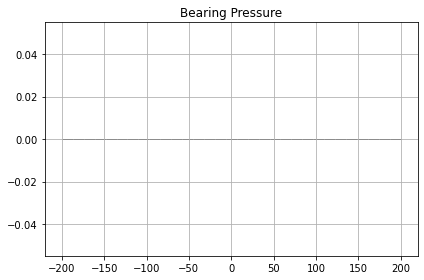

In [34]:
error_df[0].hist(bins=31, range=(-200, 200), edgecolor="k").set_title('Bearing Pressure')
plt.tight_layout()

In [ ]:
errors are too large for these axis.

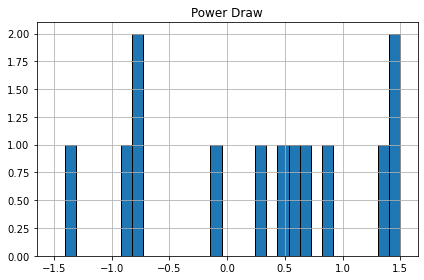

In [35]:
error_df[1].hist(bins=31, range=(-1.5, 1.5), edgecolor="k").set_title('Power Draw')
plt.tight_layout()

As we can see, the current best performing model is significantly worse than the baseline. Though this is not  completely unexpected due to the fact that the baseline effectively accounts for the oscilating a lot better rather than trying to fit the oscillations onto a line, how badly the model seems to be performing is likely a bug in the display or development. 

Furthermore, we would expect the "smarter" models to perform better, or at least as well. Perhaps this would be the case if all the data were used and parameters were fine tuned more. Though, with how badly they scored, a bug somewhere in the RandomSearchCV section of fit_model. 